In [4]:
import sys

sys.path.append("../../")
import pandas as pd
import torch
import numpy as np
import datetime

# that is something to
import os
from pprint import pprint
import math
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 20)

plt.style.use("classic")
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams["axes.formatter.limits"] = [-1000000000, 1000000000]

In [5]:
from fredapi import Fred

fred = Fred(api_key="86962d243cd55992a83872d88f46e6de")

In [6]:
res = fred.search("us cpi")

size = 10
res = res.sort_values("popularity", ascending=False).head(size)
res = res.reset_index()[["title", "id", "frequency"]]
res

,title,id,frequency
0,Consumer Price Index for All Urban Consumers: ...,CPIAUCSL,Monthly
1,"Consumer Price Indices (CPIs, HICPs), COICOP 1...",USACPIENGMINMEI,Monthly
2,Consumer Price Index for All Urban Consumers: ...,CUUR0000SEFR,Monthly
3,Consumer Price Index for All Urban Consumers: ...,CUUSA211SEHA,Annual
4,Consumer Price Index for All Urban Consumers: ...,CUSR0000SAA2,Monthly
5,Research Consumer Price Index: Food and Beverages,CPIEBEV,Monthly
6,Consumer Price Index for All Urban Consumers: ...,CUSR0000SAE1,Monthly
7,"Sticky Price Consumer Price Index less Food, E...",CRESTKCPIXSLTRM157SFRBATL,Monthly
8,Consumer Price Index for All Urban Consumers: ...,CUUR0000SAS,Monthly
9,Consumer Price Index for All Urban Consumers: ...,CUUR0000SEHC01,Monthly


In [7]:
index = 2
series_name = res.iloc[index].id
original_dates = pd.Series(fred.get_series_vintage_dates(series_name))
original_dates = original_dates[original_dates.dt.year == 2024]
original_dates = original_dates.reset_index(drop=True)

<Axes: xlabel='original_date'>

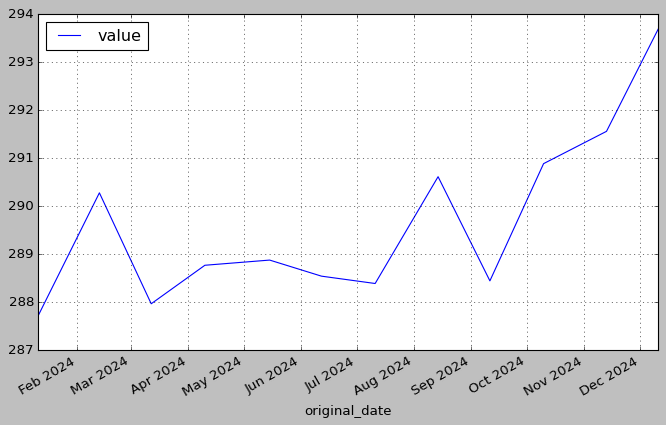

In [8]:
res = fred.get_series(series_name)
res = pd.DataFrame({"value": res[~res.isna()]})
res = res.reset_index()
res.columns = ["wrong_dt", "value"]
res = res[res.wrong_dt.dt.year >= original_dates.iloc[0].year]
res = res.reset_index(drop=True)
res = res.drop(columns=["wrong_dt"])

assert res.shape[0] == original_dates.shape[0]

res["original_date"] = pd.to_datetime(original_dates)
res = res.set_index("original_date")
res.plot()

### FX Street Calendar

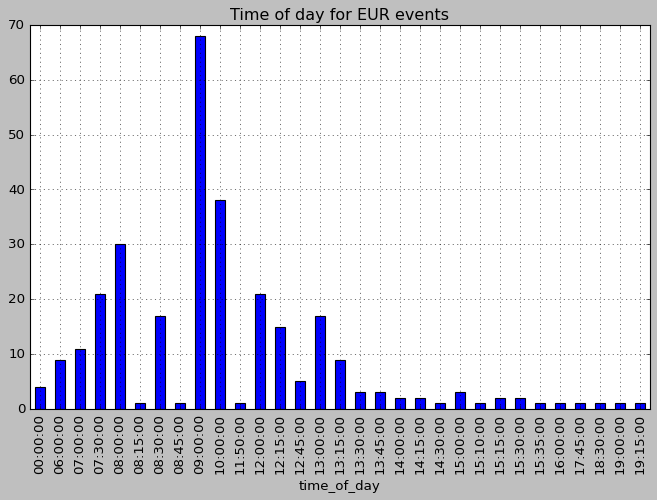

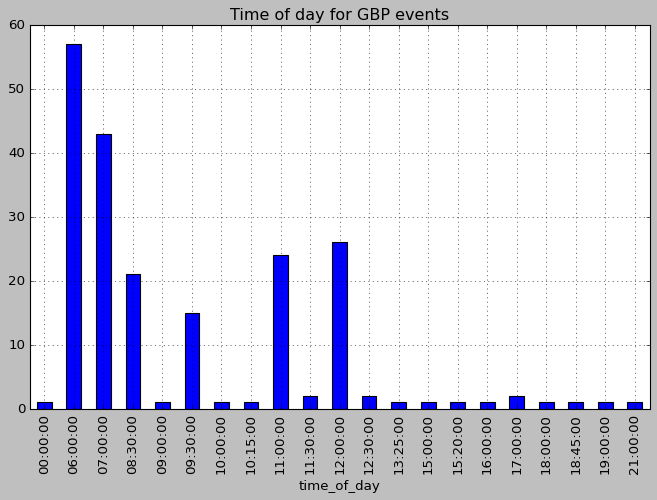

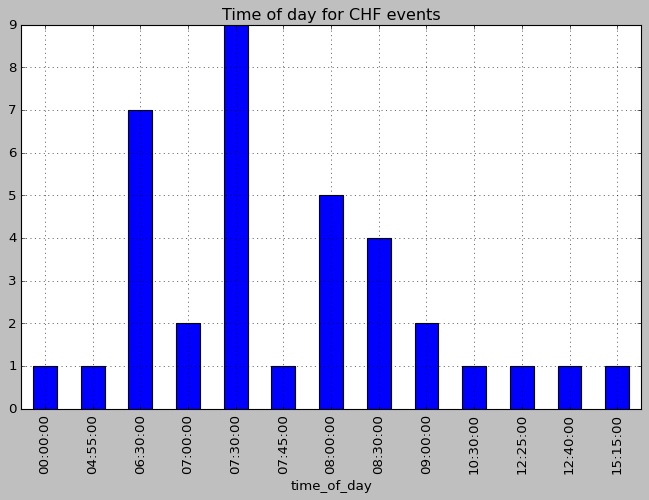

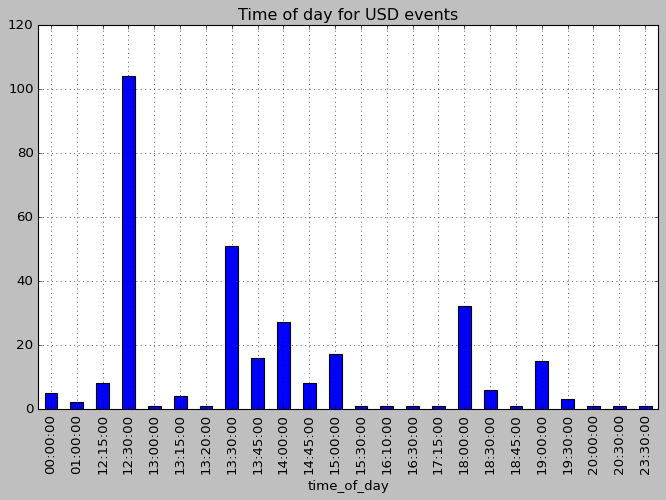

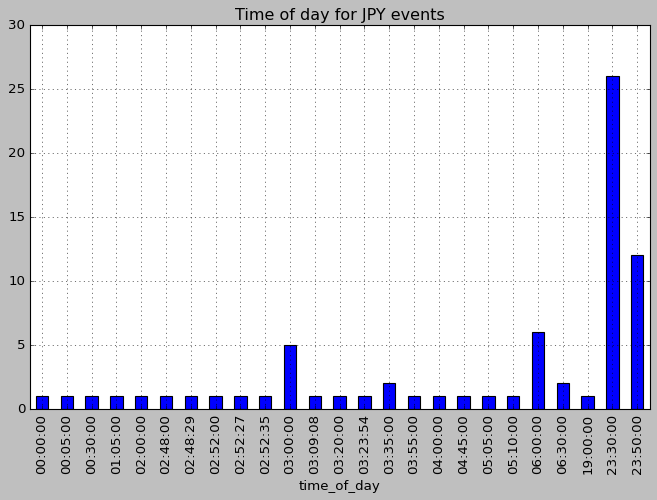

In [109]:
currency = "USD"

calendar = pd.read_csv("../data/economic-calendar.csv")
calendar = calendar[["Name", "Start", "Currency", "Impact"]]
calendar.columns = ["event", "start_date", "country", "impact"]
calendar = calendar[calendar["impact"] != "NONE"]

for currency in ["EUR", "GBP", "CHF", "USD", "JPY"]:
    res = (
        calendar[(calendar.country == currency) & (calendar.impact == "HIGH")]
        .sort_values("event")
        .reset_index(drop=True)
    )
    res["time_of_day"] = res.start_date.apply(lambda r: r.split(" ")[-1])
    res["event_date"] = res.start_date.apply(lambda r: r.split(" ")[0])
    res.groupby("time_of_day").country.count().plot(
        kind="bar", title=f"Time of day for {currency} events"
    )
    plt.show()